In [91]:
# Importing modules

import pandas as pd
import numpy as np
import time
import re
from pprint import pprint
import joblib

#NLP
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

#plotting
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Preprocessing

In [6]:
df = pd.read_csv('highest_cleaned').drop(['Unnamed: 0'],axis=1)
df.head()

,content,top_1_score,top_2_score,Corrected_content,word_counts,lang,average_score
0,I understand sense we do these notes it hel...,4,3,I understand sense we do these notes it helps ...,634,en,3.5
1,"Over the course of the six weeks, I was consta...",4,3,"Over the course of the six weeks, I was consta...",566,en,3.5
2,I feel like I made my best improvements in exp...,3,4,I feel like I made my best improvements in exp...,407,en,3.5
3,*The knowledge checks and quizzes prepared me...,4,3,*The knowledge checks and quizzes prepared me ...,403,en,3.5
4,The study activity that I found the most helpf...,3,4,The study activity that I found the most helpf...,397,en,3.5


In [7]:
stop_words = stopwords.words('english')
stop_words.extend(['mr', 'mrs', 'miss', 'ms', 'ahh', 'ah', 'want', 'feel', 'want'])

In [8]:
def get_wordnet_pos(word):
    '''
    tags parts of speech to tokens
    Expects a string and outputs the string and its part of speech
    '''
    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def word_lemmatizer(text):
    '''
    lemamtizes the tokens based on their part of speech
    Expects a lits of tokens and outputs a list of lemmatized tokens
    '''
    
    lemmatizer = WordNetLemmatizer()
    text = lemmatizer.lemmatize(text, get_wordnet_pos(text))
    return text


def reflection_tokenizer(text):
    '''
    Tokenizes a list of string, expects a list of strings and outputs a list of strings.
    before tokenizing:
    1)removes the non-alphanumeric charcaters like emojies
    2)removes the numbers
    3)lower cases the words
    4)tokenizes the sentences
    5)lemmatizes teh tokens
    6)removes the tokens in stop words list
     '''
    
    text=re.sub(r'[\W_]+', ' ', text)
    text=re.sub(r'\d+', '', text) 
    text = text.lower()
    tokens = [word for word in word_tokenize(text)]
    tokens = [word for word in tokens if len(word) >= 3]
    tokens = [word_lemmatizer(w) for w in tokens]
    tokens = [s for s in tokens if s not in stop_words]
    return tokens

In [9]:
df['lemmatize_token'] = df.Corrected_content.apply(reflection_tokenizer)

In [10]:
df.head()

,content,top_1_score,top_2_score,Corrected_content,word_counts,lang,average_score,lemmatize_token
0,I understand sense we do these notes it hel...,4,3,I understand sense we do these notes it helps ...,634,en,3.5,"[understand, sense, note, help, understand, cl..."
1,"Over the course of the six weeks, I was consta...",4,3,"Over the course of the six weeks, I was consta...",566,en,3.5,"[course, six, week, constantly, use, pretty, s..."
2,I feel like I made my best improvements in exp...,3,4,I feel like I made my best improvements in exp...,407,en,3.5,"[like, make, best, improvement, expand, idea, ..."
3,*The knowledge checks and quizzes prepared me...,4,3,*The knowledge checks and quizzes prepared me ...,403,en,3.5,"[knowledge, check, quiz, prepared, exam, help,..."
4,The study activity that I found the most helpf...,3,4,The study activity that I found the most helpf...,397,en,3.5,"[study, activity, found, helpful, review, know..."


In [11]:
df.shape

(23150, 8)

In [12]:
df.to_csv('data_lemmatized')

In [13]:
#Convert a collection of text documents to a matrix of token counts, matrix of documents and tokens
token_vectorizer = CountVectorizer(tokenizer = reflection_tokenizer, min_df=10)

In [14]:
#function maps the column of the dataframe to a matrix of documents in the rows and token counts as columns,
# this is bag of words representation of the documents
X = token_vectorizer.fit_transform(df.Corrected_content)

In [15]:
type(X)

scipy.sparse.csr.csr_matrix

In [16]:
X.shape

(23150, 2271)

In [17]:
#np.savetxt('X.txt', X)

# Topic Modeling with LDA (sklearn)

In [29]:
# Instantiate LDA Model with parameters
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

In [30]:
#Build LDa model on dataset with 10 topics
lda_model.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

Diagnose model performance with perplexity and log-likelihood

In [31]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(X))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(X))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -3351479.984394724
Perplexity:  415.8277700846368
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


# GridSearch the best LDA model

In [33]:
# Define Search Param
search_params = {'n_components': [5, 10, 15, 20] , 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(X)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [34]:
# To see the best model and its parameters
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5}
Best Log Likelihood Score:  -1143232.8498240504
Model Perplexity:  403.582672355595


In [35]:
joblib.dump(best_lda_model, "LDA_5topics.pkl")

['LDA_5topics.pkl']

In [41]:
#test_score and parameters of the all models of the grid search
means = model.cv_results_['mean_test_score']
params = model.cv_results_['params']

In [92]:
#means
#params

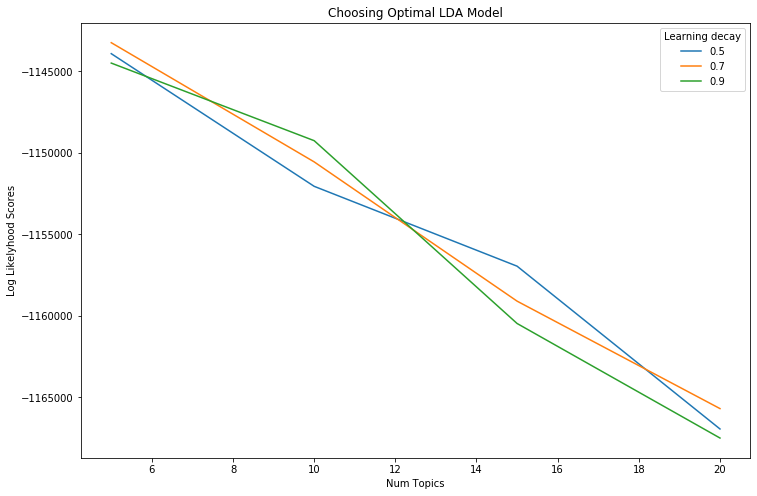

In [81]:
#Get Log Likelyhoods from Grid Search Output
n_topics = [5, 10, 15, 20]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][i]) for i in range(0,4)]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][i]) for i in range(4,8)]     
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][i]) for i in range(8,12)]
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [82]:
data = df.content.values.tolist()

 to see the dominant topic in each document

In [84]:
# Document - Topic Matrix
lda_output = best_lda_model.transform(X)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# converted to a pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'blue' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0,0.04,0.17,0.2,0.59,4
Doc1,0.01,0.02,0.06,0.23,0.68,4
Doc2,0,0.12,0.7,0.18,0,2
Doc3,0,0,0.2,0.08,0.71,4
Doc4,0,0.05,0.1,0.04,0.81,4
Doc5,0.02,0.11,0,0,0.87,4
Doc6,0.09,0,0.25,0.66,0,3
Doc7,0,0.09,0,0.55,0.36,3
Doc8,0,0.14,0.22,0.64,0,3
Doc9,0,0,0,0.78,0.22,3


Review topics distribution across documents

In [85]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,5765
1,4,5716
2,2,5035
3,0,3988
4,1,2646


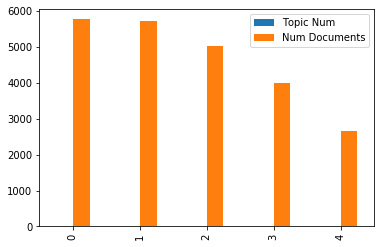

In [93]:
#topic_document distribution
df_topic_distribution.plot(kind='bar')

# LDA model with pyLDAvis

In [87]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, X, token_vectorizer, mds='tsne')
panel

/Users/shahrzad/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3     -109.512444 -118.020332       1        1  26.033367
4      268.800629 -112.275032       2        1  23.392079
2      -22.700239   69.483109       3        1  19.330100
0      176.428314   72.556740       4        1  19.231029
1       80.621437 -179.203033       5        1  12.013426, topic_info=     Category          Freq        Term         Total  loglift  logprob
884   Default   7381.000000        goal   7381.000000  30.0000  30.0000
895   Default   8654.000000       grade   8654.000000  29.0000  29.0000
1962  Default   6032.000000       study   6032.000000  28.0000  28.0000
1606  Default   3912.000000        read   3912.000000  27.0000  27.0000
2213  Default   7754.000000        week   7754.000000  26.0000  26.0000
1213  Default   3284.000000        math   3284.000000  25.0000  25.0000
1588  Default   3879.000000        quiz   3879.000000  24.0000  24.0000
1758  Default   2425.000000     science   2425.000000  23.0000  23.0000
2255  Default   3690.000000       write   3690.000000  22.0000  22.0000
2076  Default  10269.000000        time  10269.000000  21.0000  21.0000
1608  Default   2577.000000     reading   2577.000000  20.0000  20.0000
2039  Default   3999.000000        test   3999.000000  19.0000  19.0000
102   Default   3647.000000      answer   3647.000000  18.0000  18.0000
352   Default   7347.000000       class   7347.000000  17.0000  17.0000
801   Default   4288.000000      finish   4288.000000  16.0000  16.0000
1124  Default   1755.000000         lea   1755.000000  15.0000  15.0000
1581  Default   5690.000000    question   5690.000000  14.0000  14.0000
1338  Default   4464.000000        note   4464.000000  13.0000  13.0000
231   Default   1697.000000        book   1697.000000  12.0000  12.0000
2014  Default   3843.000000        take   3843.000000  11.0000  11.0000
513   Default   2124.000000         day   2124.000000  10.0000  10.0000
2159  Default   5632.000000         use   5632.000000   9.0000   9.0000
2136  Default   3576.000000  understand   3576.000000   8.0000   8.0000
147   Default   2354.000000  assignment   2354.000000   7.0000   7.0000
872   Default  13365.000000         get  13365.000000   6.0000   6.0000
1761  Default   1555.000000       score   1555.000000   5.0000   5.0000
2242  Default  13854.000000        work  13854.000000   4.0000   4.0000
1101  Default   1111.000000   knowledge   1111.000000   3.0000   3.0000
1635  Default    951.000000  reflection    951.000000   2.0000   2.0000
140   Default   3703.000000         ask   3703.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
1618   Topic5    187.192066     receive    253.829169   1.8146  -5.8768
1962   Topic5   2941.956067       study   6032.996101   1.4010  -3.1221
1606   Topic5   1941.406710        read   3912.365661   1.4184  -3.5378
513    Topic5   1127.862411         day   2124.599583   1.4859  -4.0809
2039   Topic5   1817.169248        test   3999.841688   1.3302  -3.6039
713    Topic5    666.391393       every   1277.797170   1.4681  -4.6071
1588   Topic5   1608.117252        quiz   3879.832279   1.2384  -3.7262
1394   Topic5    315.756590        page    525.692785   1.6094  -5.3540
2057   Topic5    122.400680       third    160.077618   1.8508  -6.3017
2076   Topic5   3108.761525        time  10269.262142   0.9242  -3.0670
2014   Topic5   1435.132546        take   3843.864621   1.1339  -3.8400
1323   Topic5   1417.759311        next   5261.341155   0.8078  -3.8521
1488   Topic5    435.969490       point   1011.776275   1.2773  -5.0314
1114   Topic5    547.573734        last   1582.469797   1.0579  -4.8035
1338   Topic5   1075.605495        note   4464.535733   0.6959  -4.1283
1136   Topic5    241.549609         let    502.132418   1.3874  -5.6219
24     Topic5    306.692592     achieve    742.134387   1.2355  -5.3831
2213   Topic5   1191.20

The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array.

In [88]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = token_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

df_topic_keywords.head()

,abduction,ability,able,absence,absent,absolute,absolutely,academic,academically,academy,...,year,yell,yellow,yes,yesterday,yet,young,zachery,zero,zone
Topic0,0.200004,0.202417,76.875615,2.103728,4.031989,2.235858,0.200975,274.235311,0.201989,61.141498,...,64.973036,0.203234,2.937232,182.820341,16.201425,16.488352,1.197805,30.197693,83.738162,0.203520
Topic1,0.200750,0.303123,96.779806,0.365610,22.416239,0.204490,0.201123,28.393515,2.481313,0.202421,...,54.171151,0.200406,1.398221,25.931856,0.539098,67.470970,0.204489,0.200543,0.207307,0.201715
Topic2,11.193448,47.759777,96.672681,0.200465,0.201300,0.200826,1.934142,0.202117,0.200291,0.201771,...,72.806345,0.210976,0.458089,112.447246,0.203008,21.801900,4.063928,0.201062,0.669003,0.204721
Topic3,0.200127,30.221637,1215.331206,12.130013,79.203969,10.743292,6.124108,20.968296,28.914452,0.201171,...,653.569103,18.184867,2.066502,11.287892,61.465828,153.800501,11.238750,0.200377,11.011195,28.187144
Topic4,0.205672,186.513047,857.340692,0.200185,6.146502,18.615535,6.539652,0.200761,0.201956,1.253140,...,22.480365,0.200517,7.139956,45.512665,15.590640,42.438277,4.295029,0.200325,20.374333,0.202901


to see the top 15 keywords that are representative of the topic.

In [89]:
# Show top n keywords for each topic
def show_topics(vectorizer=token_vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=token_vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,goal,grade,get,work,math,class,science,finish,try,ask,lea,improve,week,need,help
Topic 1,time,study,read,test,quiz,get,take,reading,next,book,week,day,note,score,make
Topic 2,write,use,strategy,make,answer,question,read,work,also,think,time,try,well,look,sure
Topic 3,work,week,get,class,time,grade,well,go,need,try,thing,good,finish,like,really
Topic 4,question,help,understand,note,study,well,quiz,make,get,time,learn,check,use,think,problem


In [90]:
panel = pyLDAvis.sklearn.prepare(best_lda_model, X, token_vectorizer, mds='mmds')
panel

/Users/shahrzad/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.057890  0.099697       1        1  26.033367
4     -0.009442 -0.183620       2        1  23.392079
2     -0.176659 -0.103489       3        1  19.330100
0     -0.060343  0.237410       4        1  19.231029
1      0.188554 -0.049998       5        1  12.013426, topic_info=     Category          Freq        Term         Total  loglift  logprob
884   Default   7381.000000        goal   7381.000000  30.0000  30.0000
895   Default   8654.000000       grade   8654.000000  29.0000  29.0000
1962  Default   6032.000000       study   6032.000000  28.0000  28.0000
1606  Default   3912.000000        read   3912.000000  27.0000  27.0000
2213  Default   7754.000000        week   7754.000000  26.0000  26.0000
1213  Default   3284.000000        math   3284.000000  25.0000  25.0000
1588  Default   3879.000000        quiz   3879.000000  24.0000  24.0000
1758  Default   2425.000000     science   2425.000000  23.0000  23.0000
2255  Default   3690.000000       write   3690.000000  22.0000  22.0000
2076  Default  10269.000000        time  10269.000000  21.0000  21.0000
1608  Default   2577.000000     reading   2577.000000  20.0000  20.0000
2039  Default   3999.000000        test   3999.000000  19.0000  19.0000
102   Default   3647.000000      answer   3647.000000  18.0000  18.0000
352   Default   7347.000000       class   7347.000000  17.0000  17.0000
801   Default   4288.000000      finish   4288.000000  16.0000  16.0000
1124  Default   1755.000000         lea   1755.000000  15.0000  15.0000
1581  Default   5690.000000    question   5690.000000  14.0000  14.0000
1338  Default   4464.000000        note   4464.000000  13.0000  13.0000
231   Default   1697.000000        book   1697.000000  12.0000  12.0000
2014  Default   3843.000000        take   3843.000000  11.0000  11.0000
513   Default   2124.000000         day   2124.000000  10.0000  10.0000
2159  Default   5632.000000         use   5632.000000   9.0000   9.0000
2136  Default   3576.000000  understand   3576.000000   8.0000   8.0000
147   Default   2354.000000  assignment   2354.000000   7.0000   7.0000
872   Default  13365.000000         get  13365.000000   6.0000   6.0000
1761  Default   1555.000000       score   1555.000000   5.0000   5.0000
2242  Default  13854.000000        work  13854.000000   4.0000   4.0000
1101  Default   1111.000000   knowledge   1111.000000   3.0000   3.0000
1635  Default    951.000000  reflection    951.000000   2.0000   2.0000
140   Default   3703.000000         ask   3703.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
1618   Topic5    187.192066     receive    253.829169   1.8146  -5.8768
1962   Topic5   2941.956067       study   6032.996101   1.4010  -3.1221
1606   Topic5   1941.406710        read   3912.365661   1.4184  -3.5378
513    Topic5   1127.862411         day   2124.599583   1.4859  -4.0809
2039   Topic5   1817.169248        test   3999.841688   1.3302  -3.6039
713    Topic5    666.391393       every   1277.797170   1.4681  -4.6071
1588   Topic5   1608.117252        quiz   3879.832279   1.2384  -3.7262
1394   Topic5    315.756590        page    525.692785   1.6094  -5.3540
2057   Topic5    122.400680       third    160.077618   1.8508  -6.3017
2076   Topic5   3108.761525        time  10269.262142   0.9242  -3.0670
2014   Topic5   1435.132546        take   3843.864621   1.1339  -3.8400
1323   Topic5   1417.759311        next   5261.341155   0.8078  -3.8521
1488   Topic5    435.969490       point   1011.776275   1.2773  -5.0314
1114   Topic5    547.573734        last   1582.469797   1.0579  -4.8035
1338   Topic5   1075.605495        note   4464.535733   0.6959  -4.1283
1136   Topic5    241.549609         let    502.132418   1.3874  -5.6219
24     Topic5    306.692592     achieve    742.134387   1.2355  -5.3831
2213   Topic5   1191.202718        week   7754.5001